In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
%config InlineBackend.figure_format='retina'

/Users/mlaprise/miniconda/envs/experiments/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


THE TASK:

Your task is to take this data and build a classifier to identify whether or not a user should be marked as a violator. Each line in the log data contains a separate access. If you want to know all the access a user has made, you'll need to group based on the `unique_id` field (stands for `unique user id`). A user can appear on multiple different domains on our network. So grouping by `distil_domain_id` will separate users on different domains.

The set of data is large. You don't have to use all of it. Just be prepared to justify decisions you made about how you sliced up the data.

GOAL: 

    1) Try and determine if you can ask reasonable questions about new data. 
    2) See how you respond to a moderately large data set.
    3) See how you present findings 

DELIVERABLES:

Please summarize your work and findings into a presentation (Google Sheets, Powerpoint or a IPython Notebook is fine) that you will present to us. In your presentation, please address the following:

    1. Your Method
        a. How you handled the data and why
        b. Discuss the training and classification method chosen and why
        c. Discuss the validation method(s) used, if any, and why
    2. Your Results
    3. What would you have done differently, given more time?

### Preprocessing

Let's do some preprocessing first. Working with a single huge file is not ideal, I like working with smaller files, so the first step is to split the dataset:

    tar -zxvf ds_interview.tar.gz
    split -l 3265723 input.tsv traffic_
    du -sh *
    mlaprise@Martins-MacBook-Pro distil $ du -sh *
     23G	input.tsv
    1.1G	traffic_aa
    1.1G	traffic_ab
    1.1G	traffic_ac
    1.1G	traffic_ad
    1.1G	traffic_ae
    1.1G	traffic_af
    1.1G	traffic_ag
    1.2G	traffic_ah
    1.2G	traffic_ai
    1.1G	traffic_aj
    1.1G	traffic_ak
    1.1G	traffic_al
    1.1G	traffic_am
    1.1G	traffic_an
    1.1G	traffic_ao
    1.1G	traffic_ap
    1.1G	traffic_aq
    1.1G	traffic_ar
    1.1G	traffic_as
    1.1G	traffic_at
   
The dataset is roughly **23G**. Since we are interested by the classification of the **user** we can reduce the data by computing **aggregated metrics per user**. This step could be done simply with Pandas, but since the data didn't fit completely in memory I used a small pyspark script that I ran locally on my laptop. Using pyspark, even locally, will make the file access and the spilling on disk more effective. This script takes all the visits of a user and creates a single entry for each user. To keep things simple, I did a number of assumptions:
    
    1) Each user have a single http_user_agent, ip and country
    2) A user is labelled as a "violator" if at least one of his visit is tagged as a "violation"
    3) This "violations" field will be use as the ground truth for the training.

Then, I computed aggregated metrics for each user. The schema of the output is:

 *  **user_id**: *The unique_id of the user.*
 *  **nbr_domains**: *The number of different domains visited.*
 *  **ip**: *The ip adresse of the user.*
 *  **http_user_agent**: *The user_agent of the user.*
 *  **country**: *The country of the user.*
 *  **violations**: *At least one visit of the user has been tagged as a violation.*
 *  **nbr_visits**: *The total number of visits of the user.*
 *  **nbr_violations**: *The total number of violations.*
 *  **violations_ratio**: *The ratio nbr_violations/nbr_visits.*
 *  **avg_pages_per_minute**: *The avg. value of pages_per_minute.*
 *  **avg_pages_per_session**: *The avg. value of pages_per_session.*
 *  **avg_session_length**: *The avg. value of avg_session_length.*

In [ ]:
### Pyspark Script for preprocessing

import numpy as np

from pyspark.context import SparkContext, SparkConf


def str_to_float(string):
    '''Safely convert to float'''
    if string == '\N':
        return 0.0
    return float(string)

def to_str(s):
    '''Safely convert s to a str'''
    return to_unicode(s).encode('utf-8')


def to_unicode(s):
    '''Safely convert s to a unicode'''
    if isinstance(s, unicode):
        return s
    elif isinstance(s, basestring):
        return s.decode("utf-8", "ignore")
    else:
        return unicode(s)


def user_aggregation(user_visits):
    ''' Compute per-user aggregates.
    '''
    user_id, visits = user_visits
    visits = list(visits.data)

    nbr_domains = len(set([visit[0] for visit in visits]))
    ip = visits[0][1]
    http_user_agent = visits[0][5]
    country = visits[0][6]
    violations = any([visit[7]=='true' for visit in visits])
    nbr_visits = len(visits)
    nbr_violations = sum([int(visit[7]=='true') for visit in visits])
    violations_ratio = nbr_violations / nbr_visits
    avg_pages_per_minute = np.mean([str_to_float(visit[11]) for visit in visits])
    avg_pages_per_session = np.mean([str_to_float(visit[12]) for visit in visits])
    avg_session_length =  np.mean([str_to_float(visit[13]) for visit in visits])
    return (user_id,
            nbr_domains,
            ip,
            http_user_agent,
            country,
            violations,
            nbr_visits,
            nbr_violations,
            violations_ratio,
            avg_pages_per_minute,
            avg_pages_per_session,
            avg_session_length)


if __name__=="__main__":
    sc = SparkContext()
    dataset = (sc.textFile('/Users/mlaprise/datasets/distil/traffic_*')
                 .map(lambda line: line.split('\t')))
    user_visits = dataset.map(lambda ev: (ev[8], ev)).groupByKey().map(user_aggregation)
    (user_visits.map(lambda user_agg: '\t'.join([to_str(field) for field in user_agg]))
                .repartition(16)
                .saveAsTextFile(path='/Users/mlaprise/datasets/distil/user_dataset'))

Now, the per-user dataset is much smaller (**1.8G**):

    (experiments)mlaprise@Martins-MacBook-Pro user_dataset $ du -sh *
      0B	_SUCCESS
     76M	part-00000
     79M	part-00001
     83M	part-00002
     93M	part-00003
    112M	part-00004
    138M	part-00005
    148M	part-00006
    148M	part-00007
    147M	part-00008
    147M	part-00009
    147M	part-00010
    148M	part-00011
    141M	part-00012
    112M	part-00013
     83M	part-00014
     75M	part-00015

Chances are that there is much more humans then bots. There is a lot we can say on how to handle **unbalanced** dataset like this, but for now, as a first exploratory step, we can reduce the data even more by taking a random sample of the largest class:

    dataset = (sc.textFile('/Users/mlaprise/datasets/distil/user_dataset/part-000*')
                 .map(lambda line: line.split('\t')))
    humans = dataset.filter(lambda ev: ev[5]=='False')
    bots = dataset.filter(lambda ev: ev[5]=='True')
    print float(bots.count()) / dataset.count()
    
    > 0.024001862433475997

The ratio of bots here is roughly **2.5%**. So now we can build a balanced dataset using a fraction (3%) of the human:

    reduced_dataset = sc.union([bots,humans.sample(False, 0.03)]).repartition(1)
    (reduced_dataset.map(lambda ev: '\t'.join(ev))
                    .saveAsTextFile(path='/Users/mlaprise/datasets/distil/user_dataset_reduced'))

The final dataset is now **102M and contains roughly 515k users, 50% of bots, 50% of humans **

### Training

Now we can proceed with the actual training of the classification model. There is a number of model we can use. I usually start with a simple linear model like **SGDClassifier** (wrapper arround linear models trained with stochastic gradient descent) to test the feature since it's really **fast** and gives **consistent result**. Then if the machine can afford it I try a **RandomForestClassifier**. The RandomForestClassifier can give better result on **complex data** than the linear models and also generally requires **less tuning**.

In [2]:
from patsy import dmatrices
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [3]:
field_names = ['user_id',
               'nbr_domains',
               'ip',
               'http_user_agent',
               'country',
               'violations',
               'nbr_visits',
               'nbr_violations',
               'violations_ratio',
               'avg_pages_per_minute',
               'avg_pages_per_session',
               'avg_session_length']

dataset_df = pd.read_csv('/Users/mlaprise/datasets/distil/user_dataset_reduced/part-00000',
                         delimiter='\t',
                         header=0,
                         names=field_names)

In [4]:
# The user datasat contains 515k users with 12 fields each
dataset_df.shape

(514390, 12)

We can start by using a smaller number of features and see how it goes.

In [5]:
X1 = dataset_df[['avg_pages_per_minute',
                 'avg_pages_per_session',
                 'avg_session_length',
                 'nbr_visits',
                 'nbr_domains']].values
X1 = StandardScaler().fit_transform(X1)
y = dataset_df.violations.astype(int).values

We also need to define a test method. Here's we are going to use a classic 20/80 cross-validation which means that we train the model on 80% of the data and test the trained model on the remaining 20%. We performs this test multiple time and takes the average. The *test_classification_model* implements this method. The "output" of the test is:

 *  the **recall**: The number of **true positive / (true positive + false negative)** which is intuitively the ability of                 the classifier to find all the positive samples.
 
 *  the **precision**: The number of **true positive / (true positive + false positive)** which is intuitively the ability                    of the classifier not to label as positive a sample that is negative.
 * the **F1 score**: 2 * (precision x recall) / (precision + recall) which is effectively a weighted average of the precision and recall

In [6]:
def test_classification_model(cls, X, y, n_iter=1, verbose=False):
    '''Test the classification model using multiple cross-validation.
    
    :param cls: The classification model.
    :param X: Feature dataset.
    :param y: Class dataset.
    :param n_iter: Number of cross-validation.
    :param verbose: Print result of each CV.
    '''
    rs = ShuffleSplit(X.shape[0], n_iter=n_iter, test_size=0.2, random_state=0)
    f1_scores = []
    precisions = []
    recalls = []
    for train_index, test_index in rs:
        X_train = X[train_index]
        y_train = y[train_index]
        clf.fit(X_train, y_train)

        X_test = X[test_index]
        y_test = y[test_index]
        pred = clf.predict(X_test)
        f1_score = metrics.f1_score(y_test, pred, average='binary')
        precision = metrics.precision_score(y_test, pred)
        recall = metrics.recall_score(y_test, pred)
        if verbose:
            print "\n###"
            print "Precision: {}".format(precision)
            print "Recall: {}".format(recall)
            print "F1 score: {}".format(f1_score)
        f1_scores.append(f1_score)
        precisions.append(precision)
        recalls.append(recall)
    print "Avg. F1 Score: {}".format(np.mean(f1_scores))
    print "Avg. Precision: {}".format(np.mean(precisions))
    print "Avg. Recall: {}".format(np.mean(recalls))

In [7]:
# Quick test using a Logistic Regression with some L2 regularization
clf = SGDClassifier(alpha=0.02, loss='log', penalty='l2', random_state=0, n_jobs=8)
test_classification_model(clf, X1, y, 5)

Avg. F1 Score: 0.255376143365
Avg. Precision: 0.796283588753
Avg. Recall: 0.152076426783


Also, aside from the paramaters in the model itself, classification model have a certain amount of tuning knobs (called hyperparameters). In order to tweak those knobs we can essentially brute force the problem by testing every combination in a certain range:

In [8]:
rs = list(ShuffleSplit(X1.shape[0], n_iter=1, test_size=0.2, random_state=0))
train_index = rs[0][0]
test_index = rs[0][1]
X_train = X1[train_index]
y_train = y[train_index]
        
param_grid = {"alpha": [0.001, 0.005, 0.01, 0.02, 0.1, 0.2],
              "penalty": ['l1', 'l2', 'elasticnet'],
              "loss": ['hinge', 'log']}
gs = grid_search.GridSearchCV(SGDClassifier(), param_grid, verbose=0)
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.001, 0.005, 0.01, 0.02, 0.1, 0.2], 'loss': ['hinge', 'log']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [9]:
# optimal parameters for the SGDClassifier
gs.best_params_

{'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l1'}

So now we know that those parameters gives the optimal result with this model, let's test the model again using those parameters:

In [27]:
clf = SGDClassifier(alpha=0.001, loss='hinge', penalty='l1', random_state=0, n_jobs=8)
test_classification_model(clf, X1[test_index], y[test_index], 5)

Avg. F1 Score: 0.840543830844
Avg. Precision: 0.871208854129
Avg. Recall: 0.811977815476


ok, now let's try a RandomForestClassifier:

In [51]:
clf = RandomForestClassifier(max_depth=None, n_estimators=60, n_jobs=8)
test_classification_model(clf, X1, y, 1)

Avg. F1 Score: 0.897345944274
Avg. Precision: 0.885011778563
Avg. Recall: 0.910028764842


Similarly, we can optimize the RandomForestClassifier hyperparameters using something like:

    param_grid = {"max_depth": [3, None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [1, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"],
                  "n_estimators": [10, 20, 40, 80]}
    gs = grid_search.GridSearchCV(RandomForestClassifier(), param_grid, verbose=2)
    gs.fit(X_train, y_train)

### Let's add the user agent and the country

In [61]:
len(dataset_df.http_user_agent.unique())

32337

The user agent might be predictive but the issue is the really high number of different user agent (32k). Such a high number will lead to 1) A huge and slow training dataset 2) A really sparse matrix which is generally not good. We could use a dimensionality reduction method, like PCA, but since there is no co-occurence it won't be really effective ( I tried it :) ). Also, the "latent features" in a reduced matrix are harder to interpret.

One way to include this feature and avoid this problem is to "normalize" each user agent by parsing them and then keeping only the OS and the Browser:

In [62]:
import pylru
from user_agents import parse as ua_parse

class UserAgentParser(object):
    def __init__(self):
        self.cache = pylru.lrucache(50000)

    def parse(self, user_agent_str):
        if user_agent_str in self.cache:
            return self.cache[user_agent_str]
        ua_object = ua_parse(user_agent_str)
        self.cache[user_agent_str] = ua_object
        return ua_object

ua_parser = UserAgentParser()

def add_parsed_ua(row):
    parsed_ua = ua_parser.parse(row.http_user_agent)
    return "{} ({})".format(parsed_ua.os.family,
                            parsed_ua.browser.family)

In [63]:
dataset_df['http_user_agent'] = dataset_df.http_user_agent.replace(np.nan, '')

In [64]:
dataset_df['parsed_ua'] = dataset_df.apply(add_parsed_ua, axis=1)

So now the parsed user agents looks like:

In [65]:
dataset_df.parsed_ua.head(5)

0       Android (Android)
1      Windows 7 (Chrome)
2    Windows XP (Firefox)
3    Windows 8.1 (Chrome)
4      Windows 7 (Chrome)
Name: parsed_ua, dtype: object

and the number of different parsed user agent is much more reasonable:

In [66]:
len(dataset_df.parsed_ua.unique())

345

We can now build the final training dataset by including the parsed user agent and the country:

In [67]:
# Using Patsy for the “one-hot” coding of the categorical feature (country, parsed_ua)
model = '''
violations ~ avg_pages_per_minute
           + avg_pages_per_session
           + avg_session_length
           + nbr_visits
           + nbr_domains
           + country
           + parsed_ua  - 1       
'''
y2, X2 = dmatrices(model, dataset_df)

In [68]:
# Converting the patsy dmatrix to a plain np array
X2_array = np.asarray(X2)
y2 = np.asarray(y2)[:,1]

In [69]:
# Scaling
X2_array = StandardScaler().fit_transform(X2_array)
X2_array.shape

(511126, 575)

In [70]:
clf = RandomForestClassifier(max_depth=None, n_estimators=80, n_jobs=8)
test_classification_model(clf, X2, y2, 1)

Avg. F1 Score: 0.90870066978
Avg. Precision: 0.899782135076
Avg. Recall: 0.917797773372


We can also look at how the number of true positive change vs the number of false positive by computing the rate of TP and TF for various probability threshold. This is what we call the ROC curve:

In [71]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

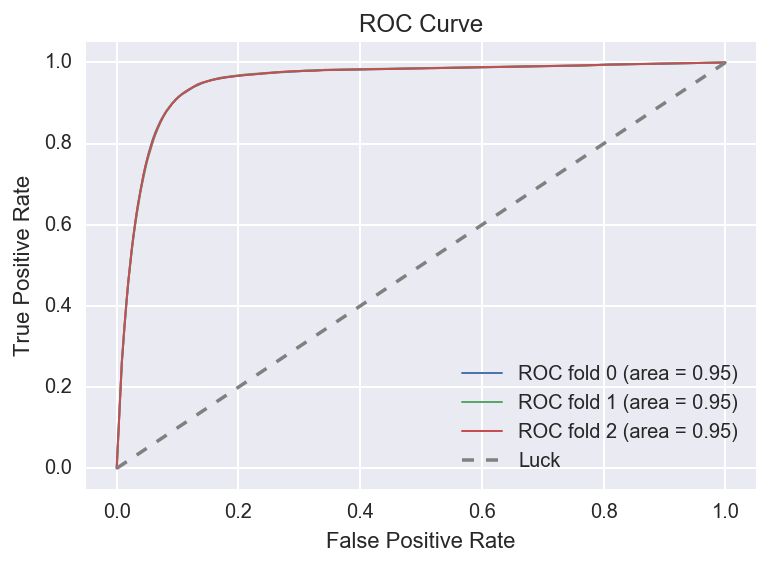

In [72]:
# ROC Curve
cv = StratifiedKFold(y, n_folds=3)

fig, ax = plt.subplots()

for i, (train, test) in enumerate(cv):
    prob = clf.fit(X1[train], y[train]).predict_proba(X1[test])
    fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

ax.plot([0, 1], [0, 1], '--', color='grey', label='Luck')


ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

We can see that the user agent and the country only **increase the performance marginally**. In a way, it's not really surprising that *avg_session_length* and *avg_pages_per_minute* is so predictive since the "ground truth" is actually coming from tagged events where the rate-limiting is one of the reason of the violations. One could argue that those metrics are **closely related to the rate-limiting**. So, in a way, what we are doing here is mostly reverse-engineering the filtering mechanism.

We can also look at the predictive power of each specific feature.

### Which feature are the most discriminative for detecting bots ?

In [29]:
feature_importance_df = pd.DataFrame(zip(X2.design_info.column_names, 100 * clf.feature_importances_), columns=['feature', 'importance'])

In [30]:
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

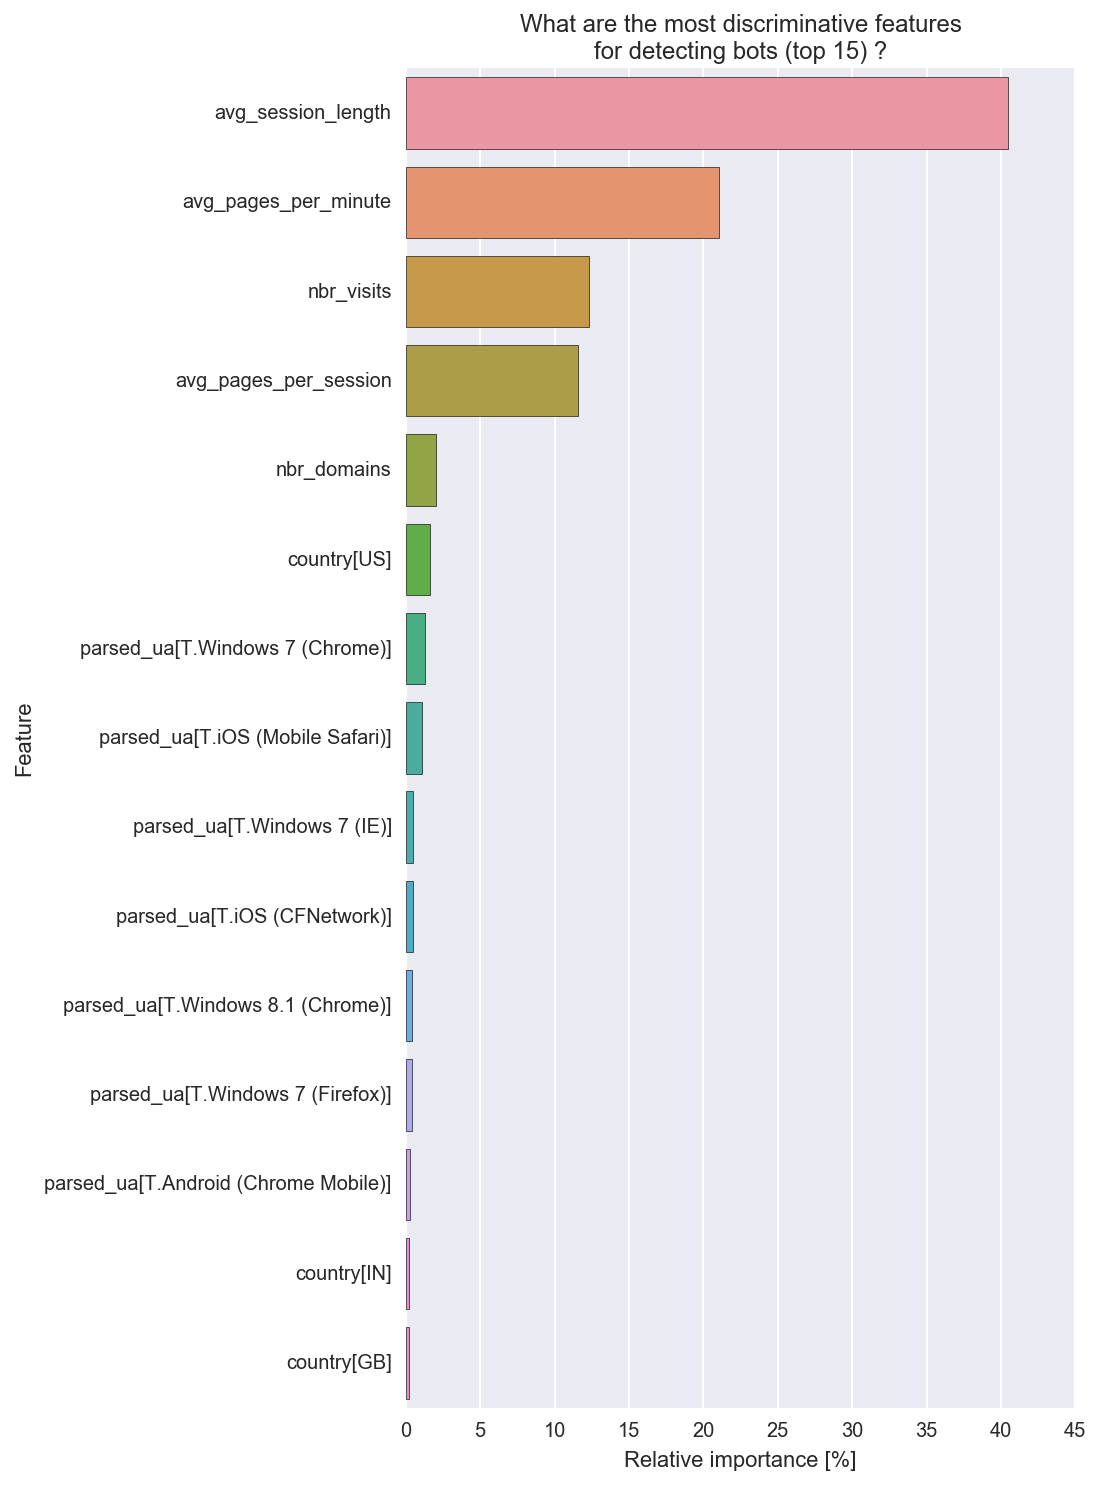

In [31]:
top_features = feature_importance_df.head(15)

fig,ax = plt.subplots(figsize=(6,12))
sns.barplot(top_features.importance, top_features.feature, ax=ax)
ax.set_xlabel('Relative importance [%]')
ax.set_ylabel('Feature')
ax.set_title('What are the most discriminative features\nfor detecting bots (top 15) ?')
plt.show()

### How does the user metrics compare between the two class ?

In [154]:
violators_metrics = dataset_df[dataset_df.violations==True][['avg_pages_per_minute',
                                                             'avg_session_length',
                                                             'avg_pages_per_session',
                                                             'nbr_visits',
                                                             'nbr_domains']].mean()

In [155]:
normal_metrics = dataset_df[dataset_df.violations==False][['avg_pages_per_minute',
                                                           'avg_session_length',
                                                           'avg_pages_per_session',
                                                           'nbr_visits',
                                                           'nbr_domains']].mean()

In [156]:
users_metrics = pd.concat([violators_metrics, normal_metrics], axis=1).rename(columns={0:'bots',1:'human'})

In [157]:
users_metrics

,bots,human
avg_pages_per_minute,1.736096,1.554349
avg_session_length,1813.955791,115.573260
avg_pages_per_session,31.507924,2.769053
nbr_visits,46.241825,5.814282
nbr_domains,1.178238,1.045337


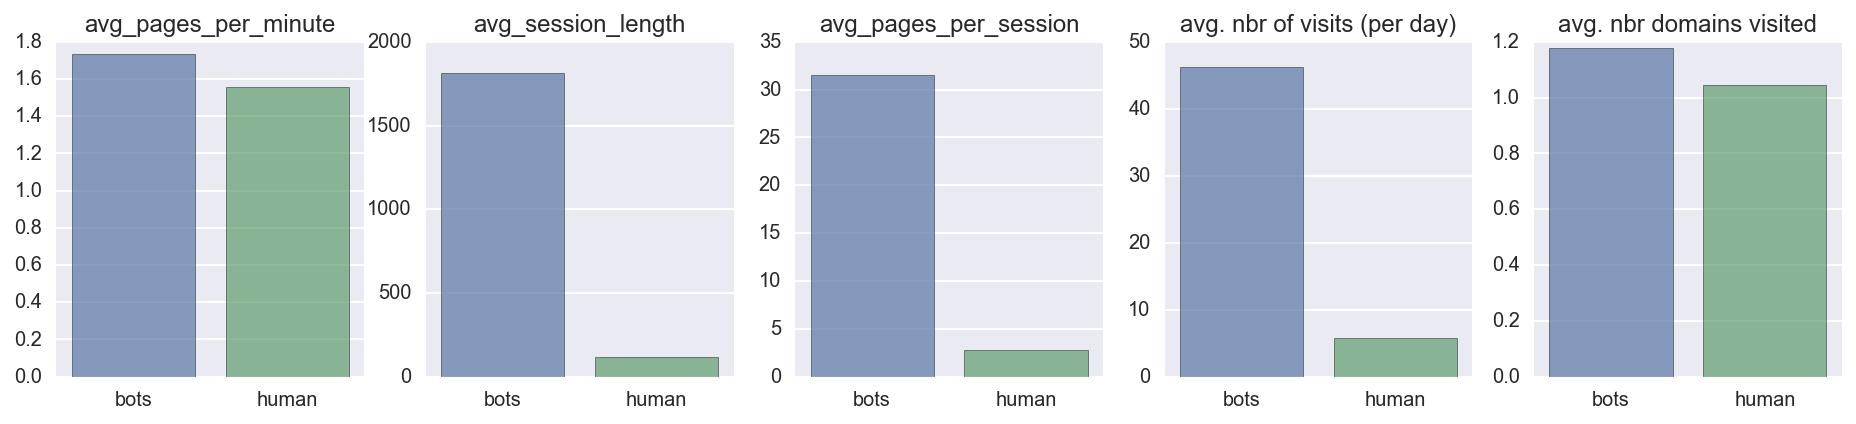

In [147]:
fig, axes = plt.subplots(1,5, figsize=(16,3))
sns.barplot(users_metrics.ix['avg_pages_per_minute'].index,
            users_metrics.ix['avg_pages_per_minute'].values, ax=axes[0], alpha=0.7)
axes[0].set_title('avg_pages_per_minute')

sns.barplot(users_metrics.ix['avg_session_length'].index,
            users_metrics.ix['avg_session_length'].values, ax=axes[1], alpha=0.7)
axes[1].set_title('avg_session_length')


sns.barplot(users_metrics.ix['avg_pages_per_session'].index,
            users_metrics.ix['avg_pages_per_session'].values, ax=axes[2], alpha=0.7)
axes[2].set_title('avg_pages_per_session')


sns.barplot(users_metrics.ix['nbr_visits'].index,
            users_metrics.ix['nbr_visits'].values, ax=axes[3], alpha=0.7)
axes[3].set_title('avg. nbr of visits (per day)')


sns.barplot(users_metrics.ix['nbr_domains'].index,
            users_metrics.ix['nbr_domains'].values, ax=axes[4], alpha=0.7)
axes[4].set_title('avg. nbr domains visited')


plt.show()

### What's the relation between the avg_session_length and the avg_pages_per_session for each class ?

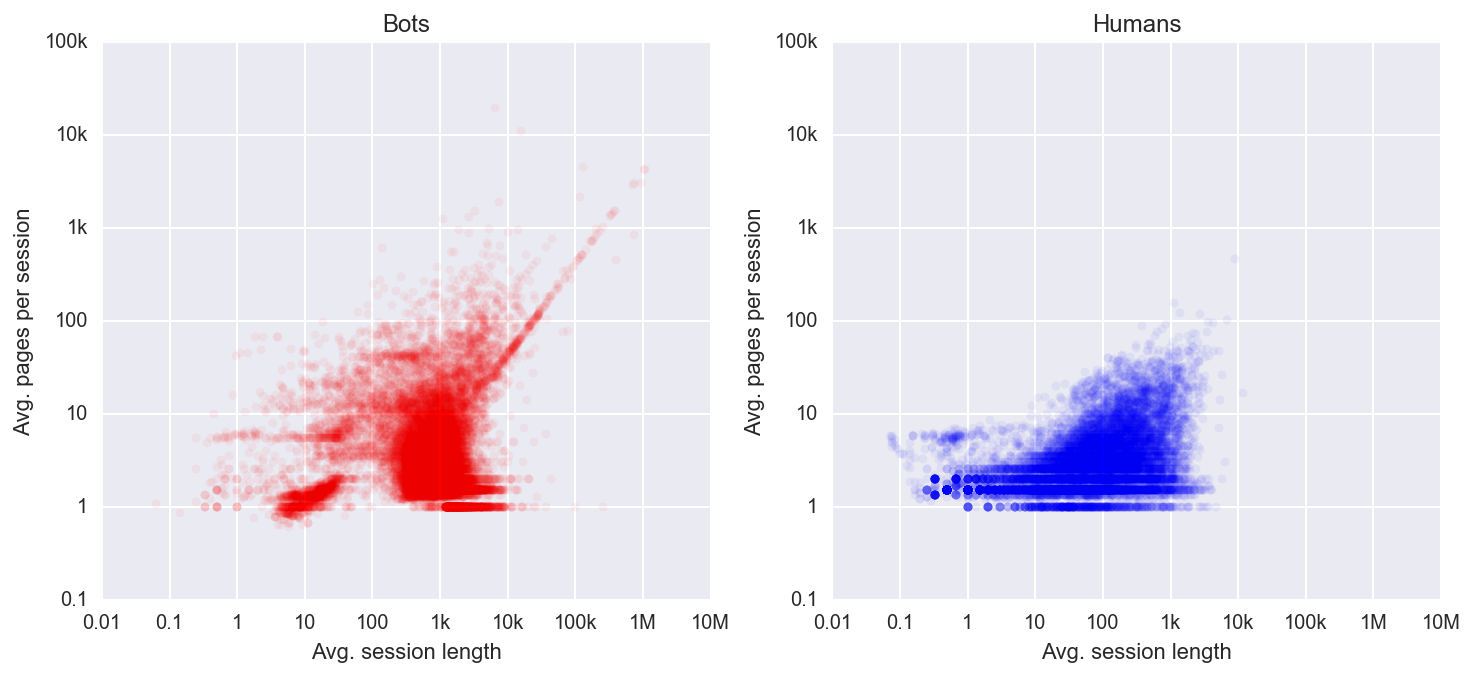

In [159]:
import matplotlib
from reportutils import int_to_human

data = dataset_df.sample(frac=0.1)[['avg_session_length', 'avg_pages_per_session', 'violations']]
data['avg_session_length_log'] = np.log10(data.avg_session_length)
data['avg_pages_per_session_log'] = np.log10(data.avg_pages_per_session)

def show_lin(x, pos):                                                                                                                                                                                                                                                         
    x_lin = pow(10,x)                                                                                                                                                                                                                                       
    return int_to_human(x_lin)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.scatter(data[data.violations==True].avg_session_length_log,
            data[data.violations==True].avg_pages_per_session_log,
            alpha=0.05,
            color='red',
            lw=0)
ax1.set_xlabel('Avg. session length')
ax1.set_ylabel('Avg. pages per session')

formatter = matplotlib.ticker.FuncFormatter(show_lin)
ax1.yaxis.set_major_formatter(formatter) 
ax1.xaxis.set_major_formatter(formatter) 

ax2.scatter(data[data.violations==False].avg_session_length_log,
           data[data.violations==False].avg_pages_per_session_log,
            alpha=0.05,
            lw=0)
ax2.set_xlabel('Avg. session length')
ax2.set_ylabel('Avg. pages per session')
ax2.set_xlim([-2,7])
ax2.set_ylim([-1,5])
ax2.yaxis.set_major_formatter(formatter) 
ax2.xaxis.set_major_formatter(formatter) 
ax2.set_title('Humans')
ax1.set_title('Bots')

plt.show()

Interestingly, the relations between the two metrics is much more "organic" in the case humans case. In the bots case, we can see a number of "artifacts". Those artifacts are most likely coming from the bots themselve but also from the filterting mechanism.

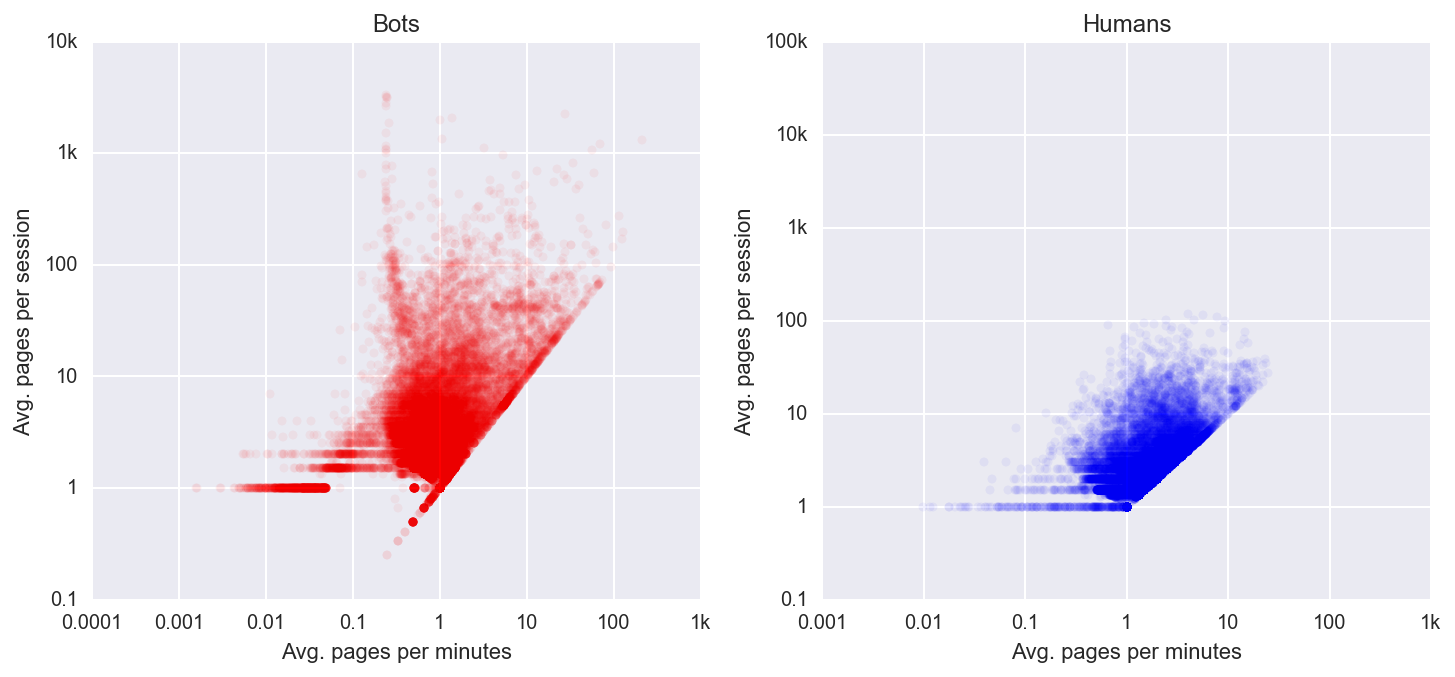

In [158]:
data = dataset_df.sample(frac=0.1)[['avg_pages_per_minute', 'avg_pages_per_session', 'violations']]
data['avg_pages_per_minute_log'] = np.log10(data.avg_pages_per_minute)
data['avg_pages_per_session_log'] = np.log10(data.avg_pages_per_session)

def show_lin(x, pos):                                                                                                                                                                                                                                                         
    x_lin = pow(10,x)                                                                                                                                                                                                                                       
    return int_to_human(x_lin)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.scatter(data[data.violations==True].avg_pages_per_minute_log,
            data[data.violations==True].avg_pages_per_session_log,
            alpha=0.05,
            color='red',
            lw=0)
ax1.set_xlabel('Avg. pages per minutes')
ax1.set_ylabel('Avg. pages per session')

formatter = matplotlib.ticker.FuncFormatter(show_lin)
ax1.yaxis.set_major_formatter(formatter) 
ax1.xaxis.set_major_formatter(formatter) 

ax2.scatter(data[data.violations==False].avg_pages_per_minute_log,
           data[data.violations==False].avg_pages_per_session_log,
            alpha=0.05,
            lw=0)
ax2.set_xlabel('Avg. pages per minutes')
ax2.set_ylabel('Avg. pages per session')
ax2.set_xlim([-3,3])
ax2.set_ylim([-1,5])
ax2.yaxis.set_major_formatter(formatter) 
ax2.xaxis.set_major_formatter(formatter) 
ax2.set_title('Humans')
ax1.set_title('Bots')

plt.show()

The End !